In [572]:
import pandas as pd
import plotly.express as px
import datetime as dt
df = pd.read_csv("train.csv",index_col=0)
df.Datum = pd.to_datetime(df["Datum"])
df.set_index(df["Datum"],inplace=True)

df["Arbeitszeit"] = (df["Datum"].dt.hour.between(8,17))&(df["Datum"].dt.dayofweek < 5)&~((df["Datum"].dt.hour==13)&(df["Datum"].dt.minute.between(0,20)))
df.drop(["Datum","Wassergehalt"],axis=1,inplace=True)
df.dropna(inplace=True)


df_test = pd.read_csv("test.csv",index_col=0)
df_test.Datum = pd.to_datetime(df_test["Datum"])
df_test.set_index(df_test["Datum"],inplace=True)
df_test["Arbeitszeit"] = (df_test["Datum"].dt.hour.between(8,17))&(df_test["Datum"].dt.dayofweek < 5)&~((df_test["Datum"].dt.hour==13)&(df_test["Datum"].dt.minute.between(0,20)))
df_test.drop(["Datum","Wassergehalt"],axis=1,inplace=True)
df_test.dropna(inplace=True)

df_test

,Temperatur,Luftfeuchtigkeit,CO2,Arbeitszeit
Datum,,,,
2017-02-04 00:01:00,20.050000,33.545000,507.000000,False
2017-02-04 00:02:00,20.033333,33.626667,505.333333,False
2017-02-04 00:03:00,20.000000,33.590000,505.500000,False
2017-02-04 00:04:00,20.000000,33.645000,504.500000,False
2017-02-04 00:04:59,20.000000,33.626667,504.666667,False
...,...,...,...,...
2017-02-08 09:15:00,20.815000,27.717500,1505.250000,True
2017-02-08 09:16:00,20.865000,27.745000,1514.500000,True
2017-02-08 09:16:59,20.890000,27.745000,1521.500000,True


In [573]:
df.describe()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit
count,14225.000000,14225.000000,14225.000000,14225.000000
mean,21.005722,25.941156,628.075549,0.256591
std,1.148986,4.581969,279.382924,0.436767
min,19.000000,16.745000,412.750000,0.000000
25%,20.290000,22.675000,446.000000,0.000000
50%,20.830000,25.722500,512.000000,0.000000
75%,21.700000,28.650000,694.750000,1.000000
max,24.408333,39.117500,2028.500000,1.000000


## Ausreißer werden entfernt
- macht keinen großen Unterschied für die Performance aber etwas sauberer
- fehlende Werte füllen wir nicht auf weil es nicht genug Daten gibt um sie verlässlich intelligent zu füllen


In [574]:
features = ["Luftfeuchtigkeit", "Temperatur", "CO2"]
for feature in features:
    df[f"Ausreisserdropper{feature}"] = df[feature]/df[feature].shift(1)
#    df = df[~df["Ausreisserdropper"].between(0.998,1.002)]
#    cols = ['col_1', 'col_2'] # one or more
    Q1 = df[f"Ausreisserdropper{feature}"].quantile(0.04)
    Q3 = df[f"Ausreisserdropper{feature}"].quantile(0.96)
    IQR = Q3 - Q1
    df = df[~((df[f"Ausreisserdropper{feature}"] < (Q1 - 1.5 * IQR)) |(df[f"Ausreisserdropper{feature}"] > (Q3 + 1.5 * IQR)))]
#px.histogram(df[~df["Ausreisserdropper"].between(0.996,1.004)],x="Ausreisserdropper")
df.drop(columns=["AusreisserdropperTemperatur","AusreisserdropperLuftfeuchtigkeit","AusreisserdropperCO2"],inplace=True)
df.dropna(inplace=True)

df['Date'] = df.index.date
mask = df.Date != pd.to_datetime('2017-02-02')
df = df[mask]
df.drop(["Date"],axis=1,inplace=True)

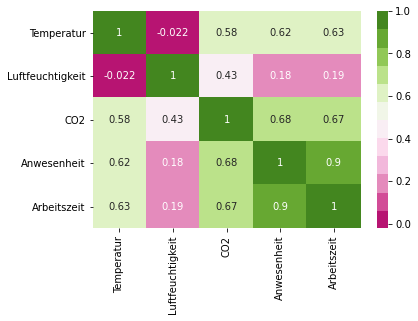

In [575]:
from seaborn import heatmap, color_palette
#heatmap(df.drop(columns="Anwesenheit").corr(),annot=True,cmap=color_palette("PiYG", 12))
heatmap(df.corr(),annot=True,cmap=color_palette("PiYG", 12))

#heatmap(df_test.corr(),annot=True,cmap=color_palette("PiYG", 12)) 
#Negativer statt positiver Zusammenhang für Luftfeuchtigkeit und CO2 bei den echten Testdaten!

In [576]:
px.bar(df.resample("h").mean(),y="CO2",color="Anwesenheit")

## Funktion fürs Training

In [578]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, plot_roc_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


label = "Anwesenheit"

def train_model(classifier,label=label,scaler=None):
    print(pd.DataFrame(columns=df.columns))
    X = df.drop(columns=[label])
    y = df[label]
    if scaler:
        X = scaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
    
    m = classifier(args)
    %time m.fit(X_train, y_train)
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train)))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))
    
    fpr, tpr, thresholds = roc_curve(y_test,m.predict(X_test))
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
    display.plot()

def report(m):
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train),digits=3))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))

def scale_features(scaler, X_train=X_train, X_test=X_test):
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

def test_viz(m):
    if 'Anwesenheit' in df_test:
        df_test.drop(columns="Anwesenheit",inplace=True)
    df_test["Anwesenheit"] = m.predict(df_test)
    px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
    df_test.drop(columns="Anwesenheit",inplace=True)

## Logistische Regression

In [579]:
#train_model(classifier=linear_model.LogisticRegression,scaler=MinMaxScaler)
print(pd.DataFrame(columns=df.columns))
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)
scale_features(StandardScaler)

mLR = linear_model.LogisticRegression()
%time mLR.fit(X_train, y_train)

report(mLR)
#print("Echte Testdaten:\n",classification_report(df_test[label],m.predict(df_test.drop(columns=[label]))))
test_viz(mLR)

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Wall time: 56 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.980     0.967     0.973      6953
           1      0.913     0.947     0.930      2576

    accuracy                          0.961      9529
   macro avg      0.947     0.957     0.952      9529
weighted avg      0.962     0.961     0.962      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.985     0.967     0.976      2362
           1      0.908     0.958     0.933       815

    accuracy                          0.964      3177
   macro avg      0.947     0.962     0.954      3177
weighted avg      0.966     0.964     0.965      3177



## Random Forest

In [580]:
#train_model(classifier=RandomForestClassifier,scaler=MinMaxScaler)
print(pd.DataFrame(columns=df.columns))
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)
scale_features(StandardScaler)

mRF = RandomForestClassifier()
%time mRF.fit(X_train, y_train)

report(mRF)
test_viz(mRF)

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Wall time: 720 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      6953
           1      1.000     1.000     1.000      2576

    accuracy                          1.000      9529
   macro avg      1.000     1.000     1.000      9529
weighted avg      1.000     1.000     1.000      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.991     0.990     0.990      2362
           1      0.971     0.974     0.972       815

    accuracy                          0.986      3177
   macro avg      0.981     0.982     0.981      3177
weighted avg      0.986     0.986     0.986      3177



## Decision Tree

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Wall time: 16 ms
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.981     0.979     0.980      6953
           1      0.944     0.950     0.947      2576

    accuracy                          0.971      9529
   macro avg      0.963     0.965     0.964      9529
weighted avg      0.971     0.971     0.971      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.984     0.979     0.981      2362
           1      0.940     0.953     0.946       815

    accuracy                          0.972      3177
   macro avg      0.962     0.966     0.964      3177
weighted avg      0.972     0.972     0.972      3177



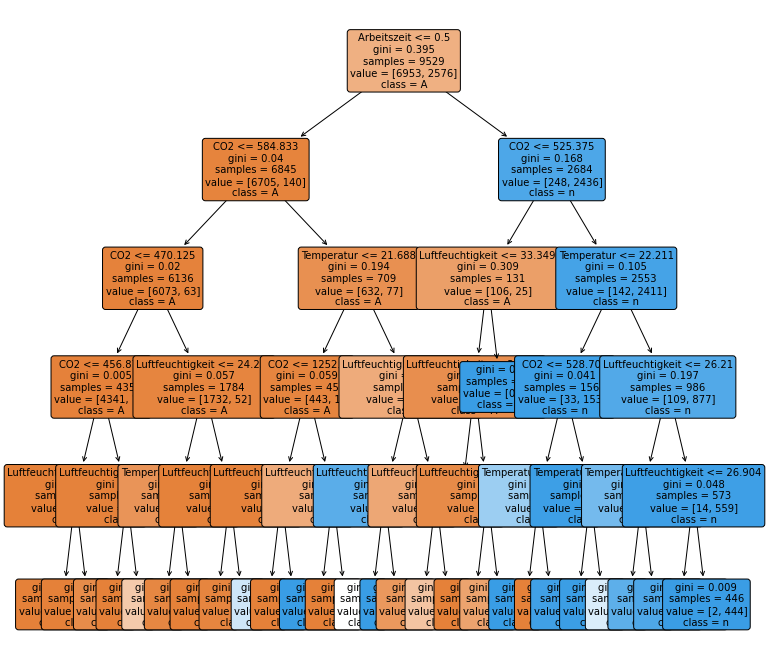

In [581]:
#train_model(classifier=DecisionTreeClassifier,scaler=MinMaxScaler)
print(pd.DataFrame(columns=df.columns))
X = df.drop(columns=[label])
X_name = feature_names=list(X.columns)
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)
scale_features(StandardScaler)


mDT = DecisionTreeClassifier(max_depth=5)
%time mDT.fit(X_train, y_train)


report(mDT)
plt.figure(figsize=(12,12))
plot_tree(mDT, rounded=True, filled=True, class_names=y.reset_index().columns[1], feature_names=X_name, fontsize=10)
plt.show(mDT)
test_viz(mDT)

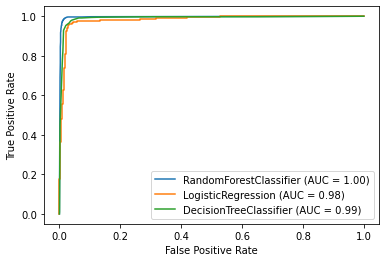

In [582]:
classifiers = [mRF,mLR,mDT]
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=plt.gca())

In [583]:
df_temp = pd.DataFrame(df_test.index,index=df_test.index)
df_temp["Anwesenheit"] = (mRF.predict(df_test) + mLR.predict(df_test) + mDT.predict(df_test))/3
#df_temp["CO2"] = df_test["CO2"]
px.bar(df_test.resample("10min").mean(),y="CO2",color=df_temp.resample("10min").mean()["Anwesenheit"])

## XGB Classifier

In [584]:
train_model(classifier=XGBClassifier,scaler=MinMaxScaler,args=use_label_encoder=False)

SyntaxError: invalid syntax (<ipython-input-584-8b86fe311398>, line 1)

## SVC

In [585]:
train_model(classifier=SVC,scaler=StandardScaler)

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []


NameError: name 'args' is not defined

In [600]:
!git add HVAC.ipynb
!git commit -m ""
#!git push

The file will have its original line endings in your working directory
